In [1]:
import numpy as np
import pandas as pd
import math

import sys
sys.path.insert(0, "../")

from dense2DkernelCNN import dense2DkernelCNN 

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Reshape, Activation, DepthwiseConv2D,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import numpy as np
import json
from telescope import telescopeMSE2

class denseSepConv2D:
    def __init__(self,name='',weights_f=''):
        self.name=name
        self.pams ={
            'CNN_layer_nodes'  : [8],  #n_filters
            'CNN_kernel_size'  : [3],
            'CNN_pool'         : [False],
            'Dense_layer_nodes': [], #does not include encoded layer
            'encoded_dim'      : 16,
            'shape'            : (4,4,3),
            'channels_first'   : False,
            'arrange'          : [],
            'arrMask'          : [],
            'n_copy'           : 0,      # no. of copy for hi occ datasets
            'loss'             : ''
        }

        self.weights_f =weights_f
        

    def setpams(self,in_pams):
        for k,v in in_pams.items():
            self.pams[k] = v

    def shuffle(self,arr):
        order = np.arange(48)
        np.random.shuffle(order)
        return arr[:,order]
            
    def prepInput(self,normData):
        shape = self.pams['shape']

        if len(self.pams['arrange'])>0:
          arrange = self.pams['arrange']
          inputdata = normData[:,arrange]
        else:
          inputdata = normData
        if len(self.pams['arrMask'])>0:
          arrMask = self.pams['arrMask']
          inputdata[:,arrMask==0]=0  #zeros out repeated entries

        shaped_data = inputdata.reshape(len(inputdata),shape[0],shape[1],shape[2])

        if self.pams['n_copy']>0:
            n_copy  = self.pams['n_copy']
            occ_low = self.pams['occ_low']
            occ_hi = self.pams['occ_hi']
        shaped_data = self.cloneInput(shaped_data,n_copy,occ_low,occ_hi)

        return shaped_data

    def weightedMSE(self, y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        loss   = K.mean(K.square(y_true - y_pred)*K.maximum(y_pred,y_true),axis=(-1))
        return loss
            
    def init(self,printSummary=True):
        encoded_dim = self.pams['encoded_dim']

        CNN_layer_nodes   = self.pams['CNN_layer_nodes']
        CNN_kernel_size   = self.pams['CNN_kernel_size']
        CNN_pool          = self.pams['CNN_pool']
        Dense_layer_nodes = self.pams['Dense_layer_nodes'] #does not include encoded layer
        channels_first    = self.pams['channels_first']

        # fix to one cnn layer for now
        nnodes=CNN_layer_nodes[0] #8
        depth_multiplier = CNN_layer_nodes[0]
        CNN_kernel=CNN_kernel_size[0] #3

        inputs = Input(shape=self.pams['shape'])
        x = inputs

        x = DepthwiseConv2D(CNN_kernel, padding='same', activation='relu',depth_multiplier=depth_multiplier)(x)

        shape = K.int_shape(x)
        #print("KINT SHAPE",shape)
        
        x = Flatten()(x)
        
        encodedLayer = Dense(encoded_dim, activation='relu',name='encoded_vector')(x)

        # Instantiate Encoder Model
        self.encoder = Model(inputs, encodedLayer, name='encoder')
        if printSummary:
          self.encoder.summary()
          plot_model(self.encoder, show_shapes=True, to_file="model1.png")

        encoded_inputs = Input(shape=(encoded_dim,), name='decoder_input')
        x = encoded_inputs

        x = Dense(shape[1]*shape[2]*shape[3], activation='relu')(x)

        x = Reshape((shape[1], shape[2], shape[3]))(x)
        
        x = Conv2DTranspose(self.pams['shape'][2], CNN_kernel_size[0], activation='relu', padding='same')(x)

        outputs = Activation('sigmoid', name='decoder_output')(x)

        self.decoder = Model(encoded_inputs, outputs, name='decoder')
        if printSummary:
          self.decoder.summary()
          plot_model(self.decoder, show_shapes=True, to_file="model2.png")

        self.autoencoder = Model(inputs, self.decoder(self.encoder(inputs)), name='autoencoder')
        if printSummary:
          self.autoencoder.summary()
          plot_model(self.autoencoder, show_shapes=True, to_file="model.png")

        if self.pams['loss']=="weightedMSE":
            self.autoencoder.compile(loss=self.weightedMSE, optimizer='adam')
            self.encoder.compile(loss=self.weightedMSE, optimizer='adam')
        elif self.pams['loss'] == 'telescopeMSE':
           self.autoencoder.compile(loss=telescopeMSE2, optimizer='adam', run_eagerly=True)
           self.encoder.compile(loss=telescopeMSE2, optimizer='adam', run_eagerly=True)
        elif self.pams['loss']!='':
            self.autoencoder.compile(loss=self.pams['loss'], optimizer='adam')
            self.encoder.compile(loss=self.pams['loss'], optimizer='adam')
        else:
            self.autoencoder.compile(loss='mse', optimizer='adam')
            self.encoder.compile(loss='mse', optimizer='adam')

        CNN_layers=''
        if len(CNN_layer_nodes)>0:
            CNN_layers += '_Conv'
            for i,n in enumerate(CNN_layer_nodes):
                CNN_layers += f'_{n}x{CNN_kernel_size[i]}'
                if CNN_pool[i]:
                    CNN_layers += 'pooled'
        Dense_layers = ''
        if len(Dense_layer_nodes)>0:
            Dense_layers += '_Dense'
            for n in Dense_layer_nodes:
                Dense_layers += f'_{n}'

        self.name = f'Autoencoded{CNN_layers}{Dense_layers}_Encoded_{encoded_dim}'
        
        if not self.weights_f=='':
            self.autoencoder.load_weights(self.weights_f)
    def get_models(self):
       return self.autoencoder,self.encoder
           
    def predict(self,x):
        decoded_Q = self.autoencoder.predict(x)
        encoded_Q = self.encoder.predict(x)
        s = self.pams['shape'] 
        if self.pams['channels_first']:
            shaped_x  = np.reshape(x,(len(x),s[0]*s[1],s[2]))
            decoded_Q = np.reshape(decoded_Q,(len(decoded_Q),s[0]*s[1],s[2]))
            encoded_Q = np.reshape(encoded_Q,(len(encoded_Q),self.pams['encoded_dim'],1))
        else:
            shaped_x  = np.reshape(x,(len(x),s[2]*s[1],s[0]))
            decoded_Q = np.reshape(decoded_Q,(len(decoded_Q),s[2]*s[1],s[0]))
            encoded_Q = np.reshape(encoded_Q,(len(encoded_Q),self.pams['encoded_dim'],1))
        return shaped_x,decoded_Q, encoded_Q

    def summary(self):
      self.encoder.summary()
      self.decoder.summary()
      self.autoencoder.summary()

    ##get pams for writing json
    def get_pams(self):
      jsonpams={}
      for k,v in self.pams.items():
          if type(v)==type(np.array([])):
              jsonpams[k] = v.tolist()
          else:
              jsonpams[k] = v 
      return jsonpams 

In [ ]:
m = denseSepConv2D()
m.init(False)

In [ ]:
m_autoCNN, m_autoCNNen = m.get_models()

In [ ]:
m_autoCNN.layers[2].input

In [ ]:
m_decoder = Model(inputs = m_autoCNN.layers[2].input,
                 outputs = m_autoCNN.layers[2].output)

In [ ]:
m_autoCNNen.summary()

In [ ]:
m_decoder.summary()

In [ ]:
m_autoCNNen.summary()

In [2]:
edim = 16
arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])
nBits_encod_total = 7
model_config =  {
        'name': "Aug14_qKeras_optA", 'ws': '', # custom
        'pams': {'shape': (4, 4, 3),                                                                                                  
                 'channels_first': False,                                                                                             
                 'arrange': arrange443,
                 'encoded_dim': edim,                                                                                                 
                 'loss': 'weightedMSE',                                                                                              
                 'nBits_encod'  : {'total':  nBits_encod_total, 'integer': 1,'keep_negative':0},                                      
                 'nBits_input'  : {'total': 10,                 'integer': 3,'keep_negative':1},                                      
                 'nBits_accum'  : {'total': 11,                 'integer': 3,'keep_negative':1},                                      
                 'nBits_weight' : {'total':  5,                 'integer': 1,'keep_negative':1},                                      
             },
         'isQK':False,
        }
m = dense2DkernelCNN()
m.setpams(model_config['pams'])
m.init(False)
m_autoCNN, m_autoCNNen = m.get_models()

print('------------\ntotal model\n------------')
print(m_autoCNN.summary())
print('------------\nencoder\n------------')
print(m_autoCNNen.summary())
print('------------\ndecoder\n------------')
print(m_autoCNN.layers[2].summary())

------------
total model
------------
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 4, 3)]         0         
_________________________________________________________________
encoder (Model)              (None, 16)                1632      
_________________________________________________________________
decoder (Model)              (None, 4, 4, 3)           1705      
Total params: 3,337
Trainable params: 3,337
Non-trainable params: 0
_________________________________________________________________
None
------------
encoder
------------
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 3)]    0                                     

In [3]:
f_raw = '../SampleSplitting_SignalAllocation/nElinks_5/ttbar_v11_eolNoise_Layer9_5Links.csv'
calQ     = np.genfromtxt(f_raw, delimiter=',',usecols=[*range(0, 48)],skip_header=2000,max_rows=10000)
sumQ     = calQ.sum(axis=1)
calQ     = calQ[sumQ>0]
sumQ     = sumQ[sumQ>0]

inputQf_48_arr   = np.array([calQ[i]/s for i,s in enumerate(sumQ)])[:,arrange443]  
inputQf_443_arr  = inputQf_48_arr.reshape(len(inputQf_48_arr),4,4,3)
inputQ_48_arr    = np.array([inputQf_48_arr[i]*s for i,s in enumerate(sumQ)])              
inputQ_443_arr   =  inputQ_48_arr.reshape(len(inputQ_48_arr),4,4,3) 

In [4]:
history = m_autoCNN.fit(inputQf_443_arr,
                        inputQf_443_arr,
                        epochs = 10)

Train on 8932 samples
Epoch 1/10
8932/8932 [==============================] - 20s 2ms/sample - loss: 85.2570
Epoch 2/10
8932/8932 [==============================] - 18s 2ms/sample - loss: 0.2022
Epoch 3/10
8932/8932 [==============================] - 19s 2ms/sample - loss: 0.1634
Epoch 4/10
8932/8932 [==============================] - 18s 2ms/sample - loss: 0.1588
Epoch 5/10
8932/8932 [==============================] - 15s 2ms/sample - loss: 0.1571
Epoch 6/10
8932/8932 [==============================] - 13s 2ms/sample - loss: 0.1555
Epoch 7/10
8932/8932 [==============================] - 16s 2ms/sample - loss: 0.1529
Epoch 8/10
8932/8932 [==============================] - 17s 2ms/sample - loss: 0.1490
Epoch 9/10
8932/8932 [==============================] - 16s 2ms/sample - loss: 0.1417
Epoch 10/10
8932/8932 [==============================] - 17s 2ms/sample - loss: 0.1350


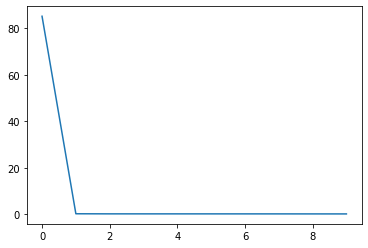

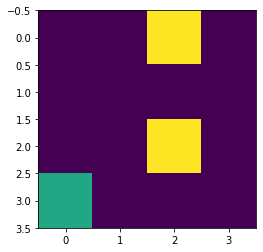

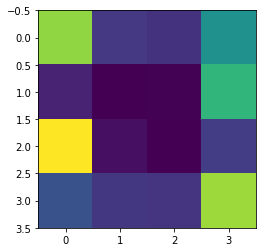

In [31]:
# check loss
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.show()

# check agreement with one sample:
plt.figure()
plt.imshow(inputQf_443_arr[0,:,:,0])
plt.figure()
plt.imshow(m_autoCNN(inputQf_443_arr[0:1])[0,:,:,0])